<a href="https://colab.research.google.com/github/ZuliiHdez/Practica2_FSI/blob/master/Red_Pelotas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

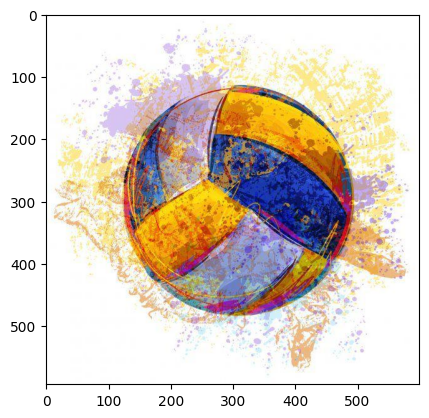

In [ ]:
train_dir = "/content/drive/MyDrive/Pelotasv3/train"
val_dir = "/content/drive/MyDrive/Pelotasv3/validation"
test_dir = "/content/drive/MyDrive/Pelotasv3/test"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open("/content/drive/MyDrive/Pelotasv3/train/volleyball/volleyball_890.jpg", 'r')
imshow(np.asarray(pil_im))


# **Data Augmentation**


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import glob

datagen = ImageDataGenerator(
  horizontal_flip=False,
	vertical_flip=False,
	rotation_range=25,
	zoom_range=0.20,
	shear_range=0.20,
	fill_mode="nearest")

for i in range(7):
  clases=("baseball","basketball","rugby_ball","football","table_tennis_ball", "tennis_ball", "volleyball")
  for name in glob.glob(train_dir+clases[i]+"/*.jpg"):
    img = load_img(name)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    j = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=train_dir+clases[i],
                              save_prefix="image", save_format='jpg'):
      j += 1
      if j >= 2:
        break
print("Aumento de datos finalizado")



Aumento de datos finalizado


In [ ]:
image_size = (150, 150)
batch_size = 32

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 273 files belonging to 7 classes.
Found 3106 files belonging to 7 classes.
Found 849 files belonging to 7 classes.


# **Model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5), offset=-1, input_shape=(150, 150, 3)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# **Start Training**

In [ ]:

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

h = model.fit(
    train_ds,
    epochs=150,
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/150
98/98 [==============================] - 22s 182ms/step - loss: 2.0995 - accuracy: 0.2199 - val_loss: 1.9047 - val_accuracy: 0.2450
Epoch 2/150
98/98 [==============================] - 21s 208ms/step - loss: 1.7724 - accuracy: 0.2933 - val_loss: 1.7956 - val_accuracy: 0.2756
Epoch 3/150
98/98 [==============================] - 20s 192ms/step - loss: 1.7191 - accuracy: 0.3055 - val_loss: 1.8217 - val_accuracy: 0.2521
Epoch 4/150
98/98 [==============================] - 19s 189ms/step - loss: 1.6667 - accuracy: 0.3155 - val_loss: 1.7782 - val_accuracy: 0.2650
Epoch 5/150
98/98 [==============================] - 21s 205ms/step - loss: 1.6363 - accuracy: 0.3352 - val_loss: 1.7703 - val_accuracy: 0.2945
Epoch 6/150
98/98 [==============================] - 20s 190ms/step - loss: 1.5831 - accuracy: 0.3509 - val_loss: 1.7296 - val_accuracy: 0.3133
Epoch 7/150
98/98 [==============================] - 20s 190ms/step - loss: 1.5427 - accuracy: 0.3812 - val_loss: 1.7737 - val_accuracy:

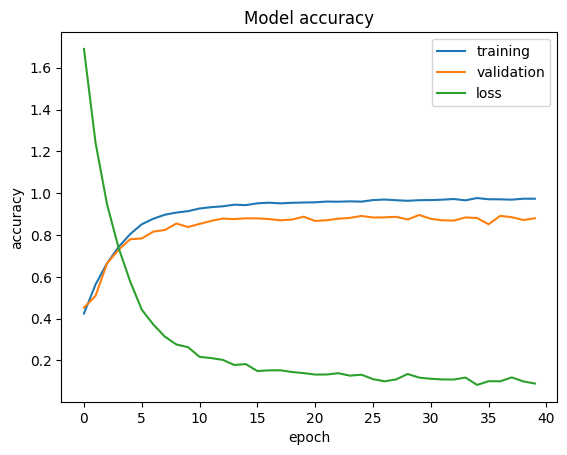

In [ ]:

import matplotlib.pyplot as plt
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()
model.save("/content/drive/MyDrive")

In [ ]:
# Evaluar el modelo en el conjunto de prueba
evaluation_results = model.evaluate(test_ds)

# Imprimir las métricas de evaluación
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

27/27 [==============================] - 2s 64ms/step - loss: 1.0202 - accuracy: 0.6702
Test Loss: 1.0202460289001465
Test Accuracy: 0.6702002286911011
